# Imports

To do:
- Naive all per stop regressor and naive per stop need to be fixed
- Applications need to be fixed

In [34]:
from capymoa.regressor import KNNRegressor, FIMTDD, AdaptiveRandomForestRegressor, SGDRegressor
from capymoa.stream import Schema
from capymoa.instance import RegressionInstance
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [4]:
import capymoa

In [5]:
capymoa.__version__

'0.8.2'

In this notebook I aim to go through all the naive approaches that were already done, and I'll build on them with some of my own ideas (+ look at a couple of applications).

In [10]:
base_regressors_to_test = [KNNRegressor, FIMTDD, AdaptiveRandomForestRegressor]

# Naive Approaches

I tried the:
- Naive all per stop regressor
- Naive per stop regressor
- Naive regressor
- Naive chunked regressor

I wanted to try the timestamp naive chunked regressor but running time was too long.

## Naive All Per Stop Regressor

In [76]:
class NaiveAllPerStopRegressor:
    def __init__(self, stop_ids, window_size=5, base_regressor=FIMTDD):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            window_size (int): Number of lag features for model to predict on
        '''

        # Set window sizes and create
        self.window_size = window_size
        self.window = []
        # Create custom schema for dataset
        self.schema = Schema.from_custom(
            feature_names=[
                f"feature_{f}_t{-t}"
                for t in range(self.window_size)
                for f in range(len(stop_ids))
            ],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )
        # Using FIMTDD as regressor
        self.regressors = {stop_id: base_regressor(self.schema) for stop_id in stop_ids}
        self.log = {stop_id:[] for stop_id in stop_ids}

    def update_window(self, value):
        """
        Updates regressor windows with an instance

        Args:
            value (int): value of instance
        """
        # Sliding window
        if len(self.window) == self.window_size:
            self.window.pop(0)
        self.window.append(value)

    def get_window(self):
        """
        Flatten the rows of data in window into a 1d array
        """
        return [item for sublist in self.window for item in sublist]

    def train(self, stop_id, target, features):
        """
        Trains regressor for stop_id on an instance

        Args:
            stop_id (str): String of stop_id data comes from
            target (float): Target value to predict
            features (array): Data to use to predict the value
        """

        # Update window
        self.update_window(features)

        # If there aren't enough instances to implement lag features can't train
        if len(self.window) < self.window_size:
            return
        
        # Build lag features and train regressor
        x = np.array(self.get_window())
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log[str(int(stop_id))].append({'x':x,'target':target})
        self.regressors[str(int(stop_id))].train(instance)

    def predict(self, stop_id):
        """
        Predicts value

        Args:
            stop_id (str): String of stop_id to predict
        """

        # Can't predict without lag features
        if len(self.window) < self.window_size:
            return 0.0
        
        # Build lag features, predict
        x = np.array(self.get_window())
        instance = RegressionInstance.from_array(self.schema, x, 0.0) # Needs target
        return self.regressors[str(int(stop_id))].predict(instance)

In [77]:
selected_model = NaiveAllPerStopRegressor

In [78]:
# Load in csv as dataframe
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

stop_ids = [
    "125960550",
    "230565994",
    "258781031",
    "43768720",
    "44072192",
    "44783654",
    "44783914",
    "44784438",
    "45833547",
    "47568123" ]

delay_steps = 6

for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    
    # Init model
    model = selected_model(stop_ids, base_regressor=base_regressor)
    
    # Error tracking
    total_abs_error = 0.0
    total_squared_error = 0.0
    count = 0
    
    # Rolling window
    error_window = 100
    abs_error_buf = 0.0
    sqrd_error_buf = 0.0
    buf_count = 0
    mae_list = []
    rmse_list = []

    # Per-stop queue of past rows (delay_steps long)
    delay_cache = defaultdict(lambda: deque(maxlen=delay_steps))
    
    # Stream through data
    for _, row in tqdm(df.iterrows(), total=len(df)):
        stop_id = row['stop']
        y_value = row['f30avg']
        x_features = row[stop_ids]

        # Predict and get error
        pred = model.predict(stop_id)
        error = pred - y_value

        # Update errors
        total_abs_error += abs(error)
        total_squared_error += error ** 2
        count += 1
        abs_error_buf += abs(error)
        sqrd_error_buf += error ** 2
        buf_count += 1

        # Add current row to cache
        delay_cache[stop_id].append((y_value, x_features))

        # If delay is satisfied, train on the oldest cached item
        if len(delay_cache[stop_id]) == delay_steps:
            old_y, old_x = delay_cache[stop_id][0]
            model.train(stop_id, old_y, old_x)
            delay_cache[stop_id].popleft()

        # Rolling window metrics
        if buf_count == error_window:
            mae = abs_error_buf / error_window
            rmse = np.sqrt(sqrd_error_buf / error_window)
            mae_list.append(mae)
            rmse_list.append(rmse)
            abs_error_buf = 0.0
            sqrd_error_buf = 0.0
            buf_count = 0

    # Final results
    mae = total_abs_error / count
    rmse = np.sqrt(total_squared_error / count)

    print(f"Final MAE: {mae:.3f}")
    print(f"Final RMSE: {rmse:.3f}")

    plt.figure()
    plt.plot(mae_list, label="MAE")
    plt.plot(rmse_list, label="RMSE")
    plt.title("MAE and RMSE over time: " + selected_model.__name__)
    plt.legend()
    plt.grid(True)
    plt.ylim((0, 100))
    plt.show()


KNNRegressor


  2%|▊                                  | 4995/218400 [00:02<02:03, 1734.91it/s]


KeyboardInterrupt: 

In [40]:
model.log['125960550'][0]

{'x': array([1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 8., 6., 0., 0., 0., 0., 0., 1.]),
 'target': np.float64(1.0)}

This has one model for every stop. Input is lag information about all stops from 5min data. Output is f30avg label.

## Naive Per Stop

In [41]:
class NaivePerStopRegressor:
    def __init__(self, stop_ids, num_features=5, base_regressor=FIMTDD):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            num_features (int): Number of lag features for model to predict on
        '''
        self.num_features = num_features
        # Set window sizes and create
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        # Create custom schema for dataset
        self.schema = Schema.from_custom(
            feature_names=[str(i) for i in range(num_features)],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )
        # Using FIMTDD as regressor
        self.regressors = {stop_id: base_regressor(self.schema) for stop_id in stop_ids}
        self.log = {stop_id: [] for stop_id in stop_ids}

    def update_window(self, stop_id, value):
        """
        Updates regressor winodws with an instance

        Args:
            stop_id (str): String of stop_id
            value (int): value of instance
        """
        window = self.windows[stop_id]
        # Sliding window
        if len(window) == self.window_size:
            window.pop(0)
        window.append(value)

    def train(self, stop_id, target, feature):
        """
        Trains regressor on an instance

        Args:
            stop_id (str): String of stop_id data comes from
            target (float): Target value to predict
        """
        # Update window
        self.update_window(stop_id, feature)

        window = self.windows[stop_id]
        # If there aren't enough instances to implement lag features can't train
        if len(window) < self.num_features:
            return
        
        # Build lag features and train regressor
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log[stop_id].append({'x':x,'target':target})
        self.regressors[stop_id].train(instance)

    def predict(self, stop_id):
        """
        Predicts value

        Args:
            stop_id (str): String of stop_id to predict from
        """
        window = self.windows[stop_id]
        # Can't predict without lag features
        if len(window) < self.num_features:
            return 0.0
        
        # Build lag features, predict
        x = np.array(window)
        instance = RegressionInstance.from_array(self.schema, x, 0.0) # Needs target
        return self.regressors[stop_id].predict(instance)

KNNRegressor


100%|████████████████████████████████████| 21840/21840 [00:29<00:00, 733.09it/s]


Final MAE: 12.820
Final RMSE: 30.156


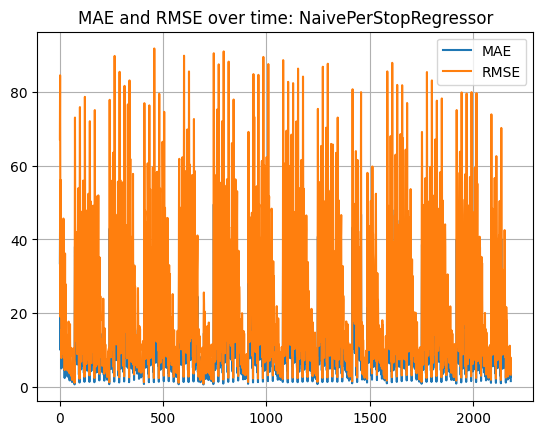

FIMTDD


100%|███████████████████████████████████| 21840/21840 [00:11<00:00, 1859.47it/s]


Final MAE: 16.803
Final RMSE: 40.547


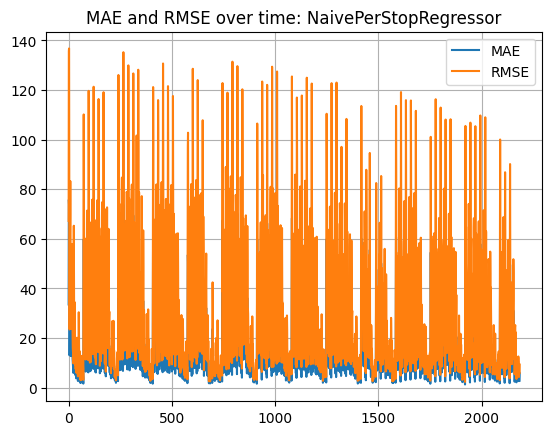

AdaptiveRandomForestRegressor


100%|████████████████████████████████████| 21840/21840 [02:49<00:00, 128.91it/s]


Final MAE: 28.077
Final RMSE: 66.334


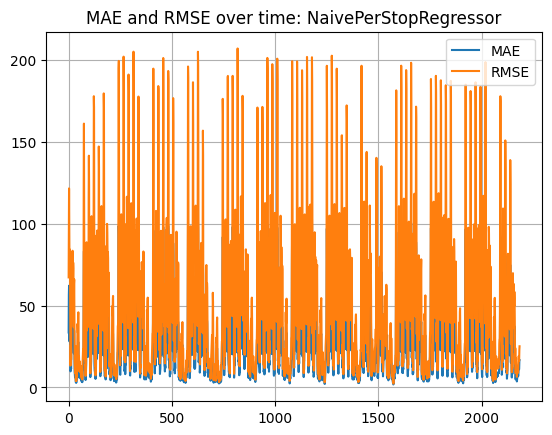

In [42]:
selected_model = NaivePerStopRegressor

# Load in csv as dataframe
df = pd.read_csv("loader_f30avg_old.csv", index_col=0)

# Get all stop ids
stop_ids = df.columns.to_list()

feature_ids = [
    "125960550",
    "230565994",
    "258781031",
    "43768720",
    "44072192",
    "44783654",
    "44783914",
    "44784438",
    "45833547",
    "47568123" ]

target_ids = [
    "125960550_f30avg",
    "230565994_f30avg",
    "258781031_f30avg",
    "43768720_f30avg",
    "44072192_f30avg",
    "44783654_f30avg",
    "44783914_f30avg",
    "44784438_f30avg",
    "45833547_f30avg",
    "47568123_f30avg"
    ]

delay_steps = 6

for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    
    # Init model
    model = selected_model(target_ids, base_regressor=base_regressor)
    
    # Error tracking
    total_abs_error = 0.0
    total_squared_error = 0.0
    count = 0
    
    # Rolling error tracking
    error_window = 100
    abs_error_buf = 0.0
    sqrd_error_buf = 0.0
    buf_count = 0
    mae_list = []
    rmse_list = []

    # Per-stop delay cache
    delay_cache = defaultdict(lambda: deque(maxlen=delay_steps))
    
    # Stream through rows
    for _, row in tqdm(df.iterrows(), total=len(df)):
        for stop_id in target_ids:
            feature_key = stop_id.split("_")[0]
            x_value = row[feature_key]
            y_value = row[stop_id]

            # Predict and get error
            pred = model.predict(stop_id)
            error = pred - y_value

            # Update errors
            total_abs_error += abs(error)
            total_squared_error += error ** 2
            count += 1
            abs_error_buf += abs(error)
            sqrd_error_buf += error ** 2
            buf_count += 1

            # Cache current instance for delayed training
            delay_cache[stop_id].append((y_value, x_value))

            # Train on delayed sample if available
            if len(delay_cache[stop_id]) == delay_steps:
                old_y, old_x = delay_cache[stop_id][0]
                model.train(stop_id, old_y, old_x)
                delay_cache[stop_id].popleft()

            # Rolling window error
            if buf_count == error_window:
                mae = abs_error_buf / error_window
                rmse = np.sqrt(sqrd_error_buf / error_window)
                mae_list.append(mae)
                rmse_list.append(rmse)
                abs_error_buf = 0.0
                sqrd_error_buf = 0.0
                buf_count = 0

    # Final metrics
    mae = total_abs_error / count
    rmse = np.sqrt(total_squared_error / count)

    print(f"Final MAE: {mae:.3f}")
    print(f"Final RMSE: {rmse:.3f}")

    # Plot
    plt.figure()
    plt.plot(mae_list, label="MAE")
    plt.plot(rmse_list, label="RMSE")
    plt.title("MAE and RMSE over time: " + selected_model.__name__)
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
model.log['125960550_f30avg'][0]

{'x': array([1, 1, 1, 1, 1]), 'target': 1.167}

This just has the lags for a singular stop. Input is lag information from 5min stop data. Output is f30avg label.

## Naive Chunked

In [58]:

class NaiveRegressorChunked:
    def __init__(self, stop_ids, num_features=5, base_regressor=FIMTDD):
        '''
        Inits regressor for naive approach

        Args:
            stop_ids (str[]): List of stop ids from file
            num_features (int): Number of lag features for model to predict on
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        
        # Queue of windows per stop for training later
        self.window_cache = {stop_id: deque() for stop_id in stop_ids}

        self.schema = Schema.from_custom(
            feature_names=[str(i) for i in range(num_features)],
            dataset_name="OccupancyPredict",
            target_type="numeric"
        )

        self.regressor = base_regressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """
        Updates all per-stop lag windows using current occupancy data

        Args:
            row (pd.Series): A row from dataframe of occupancies per stop
        """
        for stop_id in self.windows.keys():
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def predict(self, stop_id):
        """
        Predicts value and caches the current window for later training.

        Args:
            stop_id (str): Stop ID to predict from

        Returns:
            float: Predicted value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        # Copy current window and cache it
        cached_window = list(window)
        self.window_cache[stop_id].append(cached_window)

        x = np.array(cached_window)
        instance = RegressionInstance.from_array(self.schema, x, 0.0)
        return self.regressor.predict(instance)

    def train(self, stop_id, target):
        """
        Trains the regressor using the cached window from prediction time.

        Args:
            stop_id (str): Stop ID this target corresponds to
            target (float): Actual observed value
        """
        if not self.window_cache[stop_id]:
            # Nothing to train on — prediction wasn't made that far back
            return

        cached_window = self.window_cache[stop_id].popleft()
        x = np.array(cached_window)
        instance = RegressionInstance.from_array(self.schema, x, target)
        self.log.append({'x': x, 'target': target})
        self.regressor.train(instance)

This creates a shared autoregressive model. Takes five previous datapoints and predicts the next one. Does better than the others.

# New approaches

## Prequential evaluation

This is a prequential evaluation function that works with the 'naive chunked' data. I updated it so it actually works with the delayed labelling.

In [59]:
def prequential_evaluation(
    selected_model, df, context_df=None, error_window=100, plot=True,
    return_model=False, base_regressor=FIMTDD, delay_steps=6
):
    """
    Prequential evaluation simulating delayed labeling: predict at t, train on t-delay.

    Args:
        selected_model (class): Model class (must implement train, predict, update_all_windows).
        df (pd.DataFrame): Indexed by timestamp. Must include 'stop', 'f30avg', and stop columns.
        context_df (pd.DataFrame, optional): Same index as df. Extra context features.
        error_window (int): Window size for rolling MAE/RMSE.
        plot (bool): Plot metrics over time.
        return_model (bool): Return final trained model.
        base_regressor (class): Base regressor to be used inside the selected_model.
        delay_steps (int): Delay (in timesteps) before training on a sample.

    Returns:
        Final MAE, RMSE, MAE list, RMSE list (and optionally model)
    """

    df.index = pd.to_datetime(df.index)
    if context_df is not None:
        context_df.index = pd.to_datetime(context_df.index)

    stop_ids = [col for col in df.columns if col not in ["f30avg", "stop"]]
    model = selected_model(stop_ids, base_regressor=base_regressor)

    total_abs_error = 0.0
    total_squared_error = 0.0
    count = 0
    abs_error_buf = 0.0
    sqrd_error_buf = 0.0
    buf_count = 0
    mae_list = []
    rmse_list = []

    # Cache: per stop_id deque of size `delay_steps`
    delay_cache = defaultdict(lambda: deque(maxlen=delay_steps))

    for timestamp, row in tqdm(df.iterrows(), total=len(df)):
        model.update_all_windows(row)

        stop_id = str(int(row["stop"]))
        target = row["f30avg"]
        context_features = context_df.loc[timestamp] if context_df is not None and timestamp in context_df.index else None

        # Predict current
        pred = model.predict(stop_id, context_features) if context_features is not None else model.predict(stop_id)
        error = pred - target
        total_abs_error += abs(error)
        total_squared_error += error ** 2
        count += 1
        abs_error_buf += abs(error)
        sqrd_error_buf += error ** 2
        buf_count += 1

        # Add current instance to delay cache (to be trained on later)
        delay_cache[stop_id].append((target, context_features))

        # Train on the oldest instance in cache if delay_steps reached
        if len(delay_cache[stop_id]) == delay_steps:
            old_target, old_context = delay_cache[stop_id][0]
            if old_context is not None:
                model.train(stop_id, old_target, old_context)
            else:
                model.train(stop_id, old_target)
            # Now that we've trained on it, we pop it
            delay_cache[stop_id].popleft()

        # Rolling window errors
        if buf_count == error_window:
            mae = abs_error_buf / error_window
            rmse = np.sqrt(sqrd_error_buf / error_window)
            mae_list.append(mae)
            rmse_list.append(rmse)
            abs_error_buf = 0.0
            sqrd_error_buf = 0.0
            buf_count = 0

    # Final metrics
    mae = total_abs_error / count
    rmse = np.sqrt(total_squared_error / count)

    print(f"Final MAE: {mae:.3f}")
    print(f"Final RMSE: {rmse:.3f}")

    if plot:
        plt.figure()
        plt.plot(mae_list, label="MAE")
        plt.plot(rmse_list, label="RMSE")
        plt.title("MAE and RMSE over time: " + selected_model.__name__)
        plt.legend()
        plt.grid(True)
        plt.show()

    if return_model:
        return mae, rmse, mae_list, rmse_list, model
    else:
        return mae, rmse, mae_list, rmse_list


KNNRegressor


100%|█████████████████████████████████| 218400/218400 [00:39<00:00, 5535.93it/s]

Final MAE: 10.049
Final RMSE: 25.946


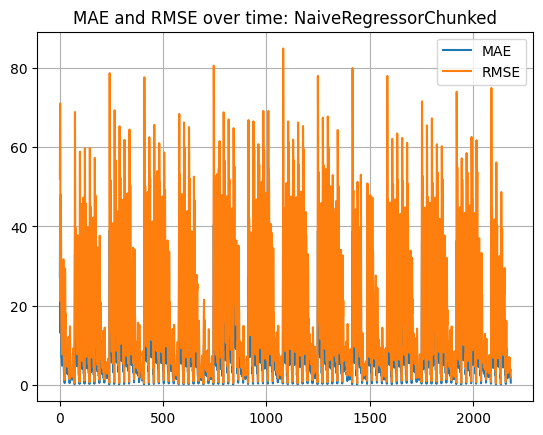

FIMTDD


100%|█████████████████████████████████| 218400/218400 [00:22<00:00, 9926.11it/s]


Final MAE: 8.040
Final RMSE: 20.017


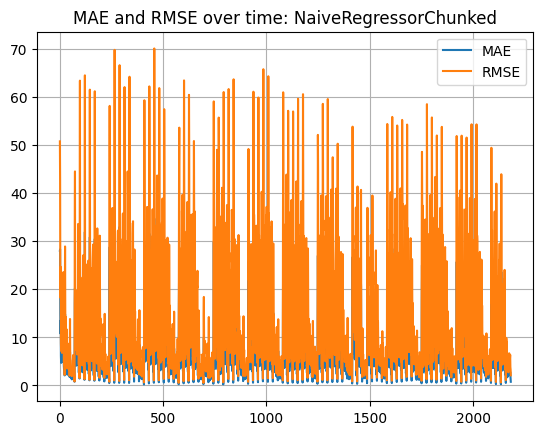

AdaptiveRandomForestRegressor


100%|█████████████████████████████████| 218400/218400 [02:09<00:00, 1681.21it/s]


Final MAE: 56.731
Final RMSE: 96.234


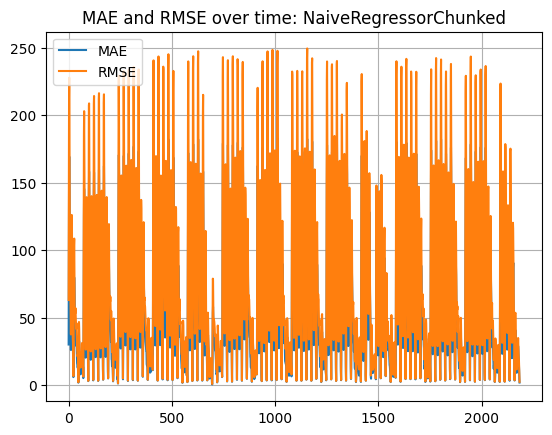

In [60]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)
for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    mae, rmse, mae_list, rmse_list = prequential_evaluation(NaiveRegressorChunked, df, base_regressor=base_regressor)

## Super Naive Model

In [61]:
class SuperNaiveModel:
    def __init__(self, stop_ids, num_features=5, base_regressor=None):
        '''
        Trivial baseline regressor that predicts the mean of the most recent lag values.

        Args:
            stop_ids (str[]): List of stop IDs
            num_features (int): Number of lag values to average
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        self.log = []

    def update_all_windows(self, row):
        """
        Updates all per-stop lag windows with raw values.

        Args:
            row (pd.Series): A row from dataframe of occupancies per stop
        """
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def train(self, stop_id, target):
        """
        No training needed for this naive model, but log data for consistency/debugging.
        """
        window = self.windows[stop_id]
        self.log.append({'x': window.copy(), 'target': target})

    def predict(self, stop_id):
        """
        Predicts the average of the most recent lag values.

        Args:
            stop_id (str): Stop ID to predict for

        Returns:
            float: Mean of the lag values or 0.0 if not enough data
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0
        return float(np.mean(window))

100%|████████████████████████████████| 218400/218400 [00:12<00:00, 16839.20it/s]


Final MAE: 7.431
Final RMSE: 17.863


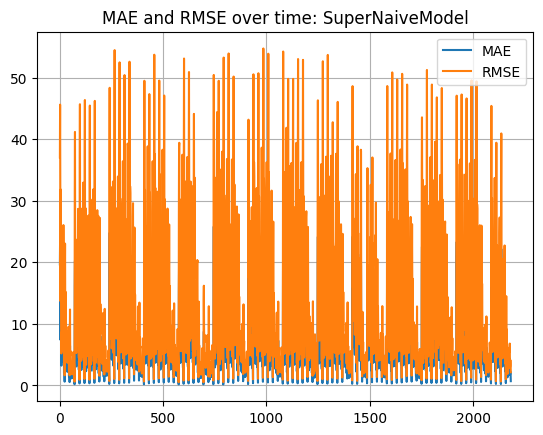

In [62]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)
mae, rmse, mae_list, rmse_list = prequential_evaluation(SuperNaiveModel, df)

## Integrated Models

To make a truly integrated model:
- We want to predict the difference between the means and the next 30 minute average
- We predict this difference using the differences between the lags

In [63]:
class NaiveRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5, base_regressor=FIMTDD):
        '''
        Differenced/integrated naive regressor.

        - Inputs: differences between consecutive values (length = num_features - 1)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags

        Args:
            stop_ids (str[]): List of stop IDs
            num_features (int): Number of lag values to maintain
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        self.window_cache = {stop_id: deque() for stop_id in stop_ids}  # For delayed training

        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)],
            dataset_name="OccupancyPredictIntegrated",
            target_type="numeric"
        )

        self.regressor = base_regressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """
        Updates per-stop lag windows with raw values (not differenced yet).

        Args:
            row (pd.Series): A row from the dataframe with all stop values
        """
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def predict(self, stop_id):
        """
        Predicts the next value as: recent mean + predicted delta.

        Args:
            stop_id (str): Stop ID

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        cached_window = list(window)  # Copy the current window
        self.window_cache[stop_id].append(cached_window)

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)

        instance = RegressionInstance.from_array(self.schema, diff_lags, 0.0)
        predicted_delta = self.regressor.predict(instance)
        return mean_lag + predicted_delta

    def train(self, stop_id, target):
        """
        Trains on the delta from the cached mean lag window.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
        """
        if not self.window_cache[stop_id]:
            return  # No prediction was made this many steps ago

        cached_window = self.window_cache[stop_id].popleft()
        if len(cached_window) < self.num_features:
            return  # Just in case

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)
        delta_target = target - mean_lag

        instance = RegressionInstance.from_array(self.schema, diff_lags, delta_target)
        self.log.append({
            'x': diff_lags.copy(),
            'mean': mean_lag,
            'target': target,
            'delta': delta_target
        })
        self.regressor.train(instance)

KNNRegressor


100%|█████████████████████████████████| 218400/218400 [01:08<00:00, 3198.11it/s]

Final MAE: 7.278
Final RMSE: 16.188


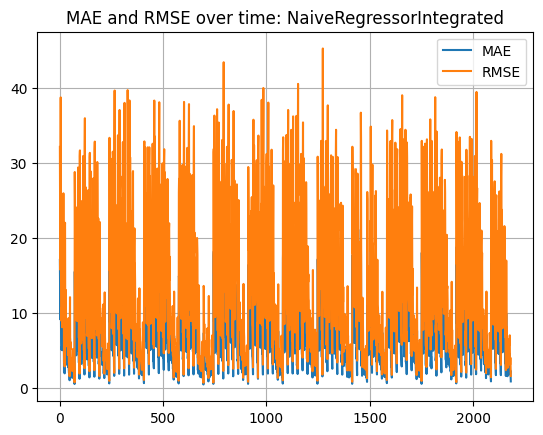

FIMTDD


100%|█████████████████████████████████| 218400/218400 [00:32<00:00, 6695.06it/s]


Final MAE: 6.741
Final RMSE: 14.658


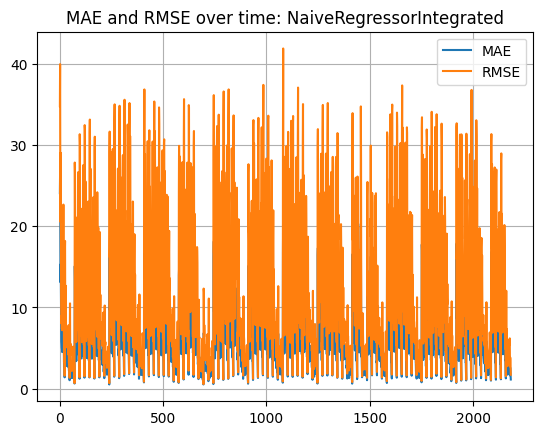

AdaptiveRandomForestRegressor


100%|█████████████████████████████████| 218400/218400 [02:15<00:00, 1614.16it/s]

Final MAE: 7.472
Final RMSE: 15.882


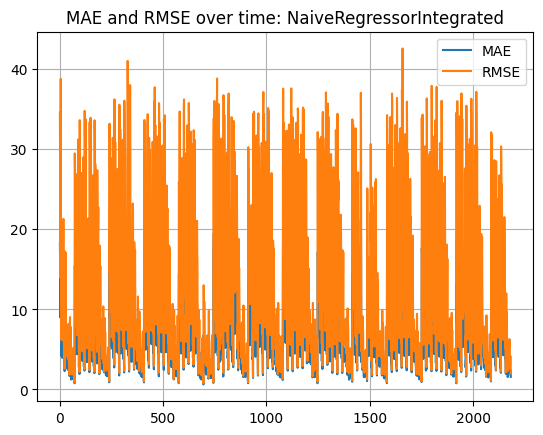

In [64]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)
for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    mae, rmse, mae_list, rmse_list = prequential_evaluation(NaiveRegressorIntegrated, df, base_regressor=base_regressor)

## Exogenous regressors

In [50]:
df_contextual_data = pd.read_csv('additional_data_03-05_2024_lagged.csv', index_col=0)

In [67]:
class SeasonalRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5, base_regressor=FIMTDD):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

        - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        self.window_cache = {stop_id: deque() for stop_id in stop_ids}  # Used to cache prediction-time windows

        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ["hour_sin", "hour_cos"],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = base_regressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        cached_window = list(window)  # Copy current window for delayed training
        self.window_cache[stop_id].append(cached_window)

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos"]].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the cached lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        if not self.window_cache[stop_id]:
            return

        cached_window = self.window_cache[stop_id].popleft()
        if len(cached_window) < self.num_features:
            return

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos"]].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({
            'x': features.copy(),
            'mean': mean_lag,
            'target': target,
            'delta': delta_target
        })
        self.regressor.train(instance)

KNNRegressor


100%|█████████████████████████████████| 218400/218400 [03:05<00:00, 1178.37it/s]


Final MAE: 6.623
Final RMSE: 13.979


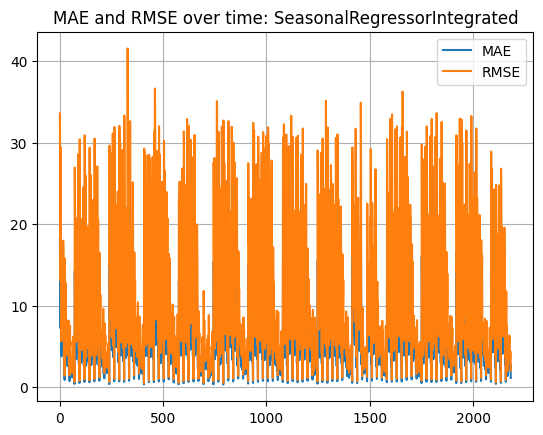

FIMTDD


100%|█████████████████████████████████| 218400/218400 [02:24<00:00, 1516.18it/s]


Final MAE: 245.818
Final RMSE: 80660.627


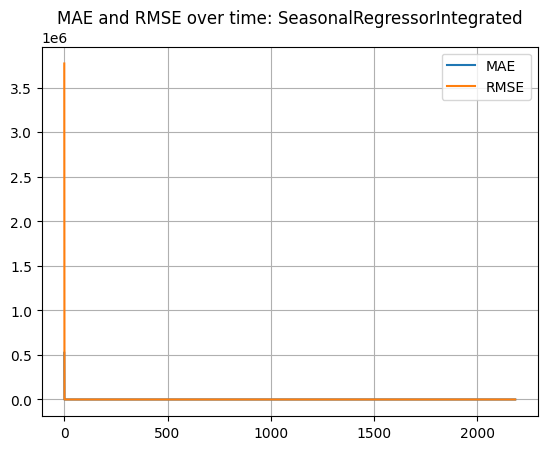

AdaptiveRandomForestRegressor


100%|██████████████████████████████████| 218400/218400 [04:57<00:00, 733.02it/s]


Final MAE: 7.796
Final RMSE: 16.615


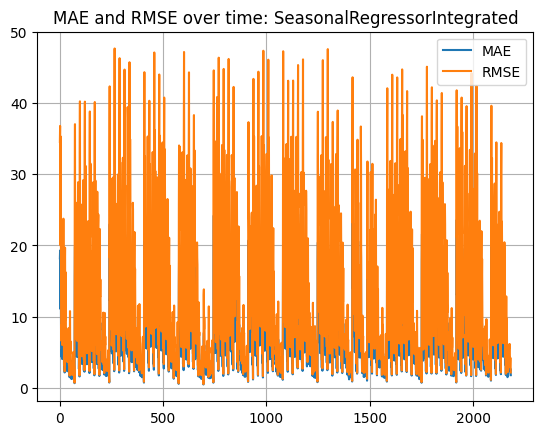

In [68]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    mae, rmse, mae_list, rmse_list, seasonal_integrated_fimtdd = prequential_evaluation(
        SeasonalRegressorIntegrated,
        df,
        context_df=df_contextual_data,
        return_model = True,
        base_regressor = base_regressor
    )

In [69]:
class TimeRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5, base_regressor=FIMTDD):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

        - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        self.window_cache = {stop_id: deque() for stop_id in stop_ids}  # Used to cache prediction-time windows

        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ["hour_sin", "hour_cos","Is_Weekend","Public_Holiday","Is_Event"],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = base_regressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        cached_window = list(window)  # Copy current window for delayed training
        self.window_cache[stop_id].append(cached_window)

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos","Is_Weekend","Public_Holiday","Is_Event"]].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the cached lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        if not self.window_cache[stop_id]:
            return

        cached_window = self.window_cache[stop_id].popleft()
        if len(cached_window) < self.num_features:
            return

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[["hour_sin", "hour_cos","Is_Weekend","Public_Holiday","Is_Event"]].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({
            'x': features.copy(),
            'mean': mean_lag,
            'target': target,
            'delta': delta_target
        })
        self.regressor.train(instance)

KNNRegressor


100%|█████████████████████████████████| 218400/218400 [03:24<00:00, 1067.91it/s]

Final MAE: 6.623
Final RMSE: 13.979


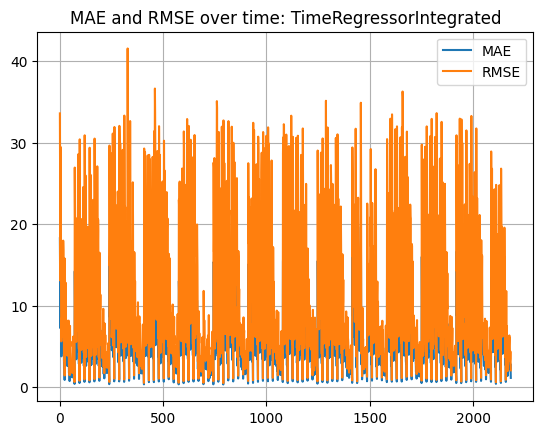

FIMTDD


100%|█████████████████████████████████| 218400/218400 [02:24<00:00, 1513.65it/s]


Final MAE: 199015993954780223041257340928.000
Final RMSE: 21507816379012720709374954176512.000


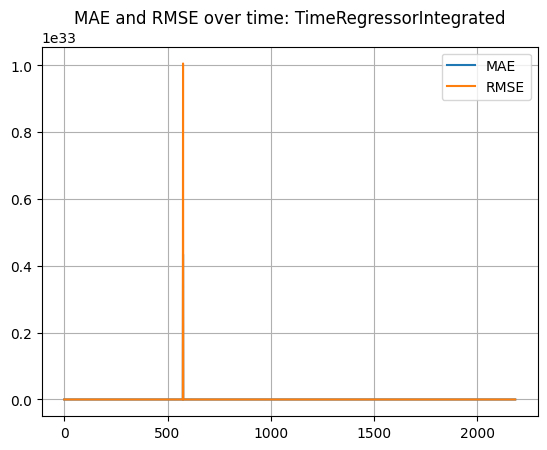

AdaptiveRandomForestRegressor


100%|██████████████████████████████████| 218400/218400 [05:00<00:00, 727.15it/s]

Final MAE: 7.591
Final RMSE: 16.348


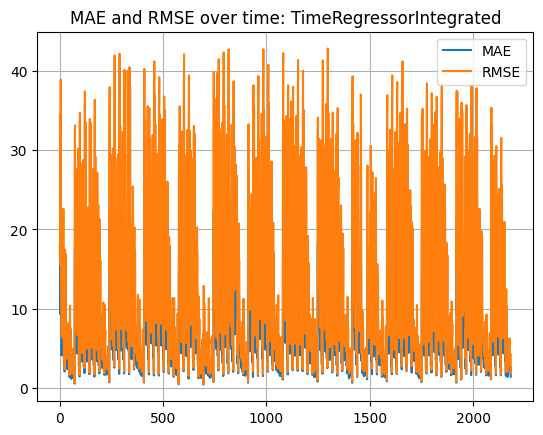

In [70]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    mae, rmse, mae_list, rmse_list = prequential_evaluation(
        TimeRegressorIntegrated,
        df,
        context_df=df_contextual_data,
        base_regressor=base_regressor
    )

In [71]:
class ExogenousRegressorIntegrated:
    def __init__(self, stop_ids, num_features=5, base_regressor=FIMTDD):
        '''
        Seasonal integrated regressor using lag differences and cyclical time features.

        - Inputs: lag differences + time features (e.g., hour_sin, hour_cos)
        - Target: future value minus mean of recent lags
        - Prediction: predicted delta added to mean of recent lags
        '''
        self.num_features = num_features
        self.window_size = num_features
        self.windows = {stop_id: [] for stop_id in stop_ids}
        self.window_cache = {stop_id: deque() for stop_id in stop_ids}  # Used to cache prediction-time windows

        self.schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(num_features - 1)] + ['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve'],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

        self.regressor = base_regressor(self.schema)
        self.log = []

    def update_all_windows(self, row):
        """Updates per-stop lag windows with raw values."""
        for stop_id in self.windows:
            value = row[str(stop_id)]
            window = self.windows[stop_id]
            if len(window) == self.window_size:
                window.pop(0)
            window.append(value)

    def predict(self, stop_id, context_features):
        """
        Predicts the next value using lag window and time features.

        Args:
            stop_id (str): Stop ID
            context_features (pd.Series): Must include hour_sin and hour_cos

        Returns:
            float: Predicted next value
        """
        window = self.windows[stop_id]
        if len(window) < self.num_features:
            return 0.0

        cached_window = list(window)  # Copy current window for delayed training
        self.window_cache[stop_id].append(cached_window)

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)

        features = np.concatenate([diff_lags, context_features[['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve']].values])
        instance = RegressionInstance.from_array(self.schema, features, 0.0)
        predicted_delta = self.regressor.predict(instance)

        return mean_lag + predicted_delta

    def train(self, stop_id, target, context_features):
        """
        Trains on the delta from the cached lag window with time features.

        Args:
            stop_id (str): Stop ID
            target (float): Actual observed target value
            context_features (pd.Series): Must include hour_sin and hour_cos
        """
        if not self.window_cache[stop_id]:
            return

        cached_window = self.window_cache[stop_id].popleft()
        if len(cached_window) < self.num_features:
            return

        diff_lags = np.diff(cached_window)
        mean_lag = np.mean(cached_window)
        delta_target = target - mean_lag

        features = np.concatenate([diff_lags, context_features[['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve']].values])
        instance = RegressionInstance.from_array(self.schema, features, delta_target)

        self.log.append({
            'x': features.copy(),
            'mean': mean_lag,
            'target': target,
            'delta': delta_target
        })
        self.regressor.train(instance)

KNNRegressor


100%|██████████████████████████████████| 218400/218400 [04:56<00:00, 735.61it/s]


Final MAE: 6.796
Final RMSE: 14.443


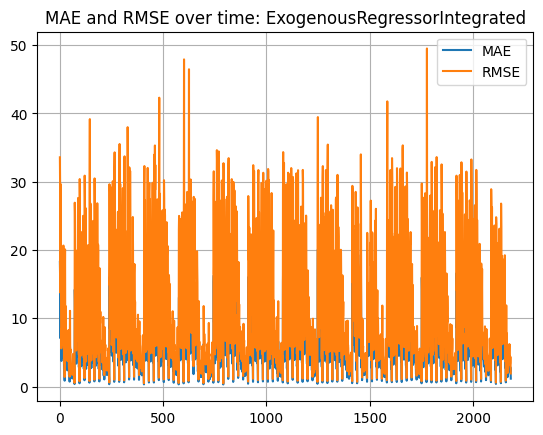

FIMTDD


100%|█████████████████████████████████| 218400/218400 [02:42<00:00, 1343.43it/s]


Final MAE: 14351713471034818367536073015296.000
Final RMSE: 1481660816780838054120591630270464.000


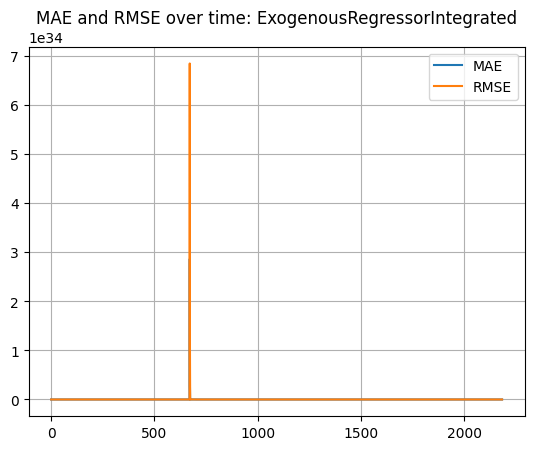

AdaptiveRandomForestRegressor


100%|██████████████████████████████████| 218400/218400 [05:04<00:00, 716.28it/s]


Final MAE: 7.551
Final RMSE: 16.340


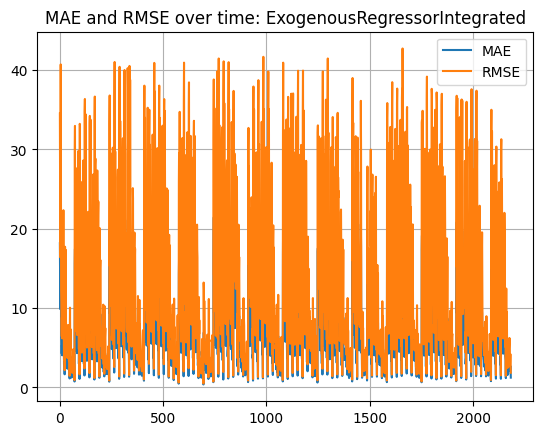

In [72]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

for base_regressor in base_regressors_to_test:
    print(base_regressor.__name__)
    mae, rmse, mae_list, rmse_list, arf_model = prequential_evaluation(
        ExogenousRegressorIntegrated,
        df,
        context_df=df_contextual_data,
        return_model = True,
        base_regressor = base_regressor
    )

# Application 1: Feature Importances

The ARF model can be broken down using streaming feature attribution.

In [33]:
ex_schema = Schema.from_custom(
            feature_names=[f"diff_{i}" for i in range(5 - 1)] + ['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve'],
            dataset_name="OccupancyPredictSeasonalIntegrated",
            target_type="numeric"
        )

def predict_with_arf_model(model,x):
    features = np.concatenate([[0,0,0,0],x])
    instance = RegressionInstance.from_array(ex_schema, features, 0.0)
    return model.regressor.predict(instance)

In [34]:
class StreamingFeatureAttributionArray:
    def __init__(self, model, predict_fn, feature_names, baseline_strategy="zero", perturb_fn=None):
        """
        Args:
            model: Trained CapyMOA model (not used directly, passed to predict_fn)
            predict_fn: Function (model, x_array) -> prediction
            feature_names: List of feature names in the same order as array input
            baseline_strategy: "zero" or "mean"
            perturb_fn: Optional function to perturb values (value, feature_name) -> new_value
        """
        self.model = model
        self.predict_fn = predict_fn
        self.feature_names = feature_names
        self.baseline_strategy = baseline_strategy
        self.perturb_fn = perturb_fn

    def explain(self, x):
        """
        Compute per-feature attribution by perturbing each feature.

        Args:
            x (np.ndarray): 1D input array with shape (n_features,)

        Returns:
            dict: feature_name -> importance score
        """
        x = np.array(x)
        base_pred = self.predict_fn(self.model, x)

        attributions = {}
        for i, name in enumerate(self.feature_names):
            x_perturbed = x.copy()

            if self.perturb_fn:
                x_perturbed[i] = self.perturb_fn(x[i], name)
            elif self.baseline_strategy == "zero":
                x_perturbed[i] = 0
            else:
                raise NotImplementedError("Only 'zero' baseline is currently supported")

            perturbed_pred = self.predict_fn(self.model, x_perturbed)
            attributions[name] = base_pred - perturbed_pred

        return attributions

In [35]:
feature_names = ['Day_Of_Week', 'Public_Holiday', 'Is_Event',
       'hour_sin', 'hour_cos', 'Is_Weekend', 'Flu_Like_Symptoms_Count',
       'Dengue_Count', 'ibov_open', 'temperature_2m', 'precipitation',
       'cloudcover', 'windspeed_10m', 'pm2_5', 'ozone',
       'us_aqi', 'onibus', 'metro', 'festival', 'trem', 'greve']

explainer = StreamingFeatureAttributionArray(
    model=arf_model,
    predict_fn=predict_with_arf_model,
    feature_names=feature_names
)
all_explanations = []

# Iterate over each row in the dataset
for idx, row in tqdm(df_contextual_data[feature_names].iterrows(),total=len(df_contextual_data)):
    x = row.values
    explanation = explainer.explain(x)
    explanation["__row__"] = idx  # tag row index for reference
    all_explanations.append(explanation)

# Convert to DataFrame: rows = instances, columns = feature importances
explanations_df = pd.DataFrame(all_explanations).set_index("__row__")

100%|████████████████████████████████████| 21840/21840 [00:36<00:00, 593.06it/s]


In [36]:
mean_importance = explanations_df.abs().mean().sort_values(ascending=False)

print("Mean absolute feature importances:")
print(mean_importance)

Mean absolute feature importances:
hour_sin                   0.051073
windspeed_10m              0.006983
hour_cos                   0.002255
temperature_2m             0.001886
Day_Of_Week                0.000000
Public_Holiday             0.000000
Is_Event                   0.000000
Is_Weekend                 0.000000
Flu_Like_Symptoms_Count    0.000000
ibov_open                  0.000000
Dengue_Count               0.000000
precipitation              0.000000
cloudcover                 0.000000
pm2_5                      0.000000
ozone                      0.000000
us_aqi                     0.000000
onibus                     0.000000
metro                      0.000000
festival                   0.000000
trem                       0.000000
greve                      0.000000
dtype: float64


The only features that are useful for improving prediction are time, windspeed, and temperature.

# Application 2: Granger Causality

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests

In [38]:
df_contextual_data_not_lagged = pd.read_csv('additional_data_03-05_2024_not_lagged.csv')[240:].reset_index(drop=True)

100%|█████████████████████████████████| 218400/218400 [02:21<00:00, 1545.12it/s]


Final MAE: 5.860
Final RMSE: 11.909


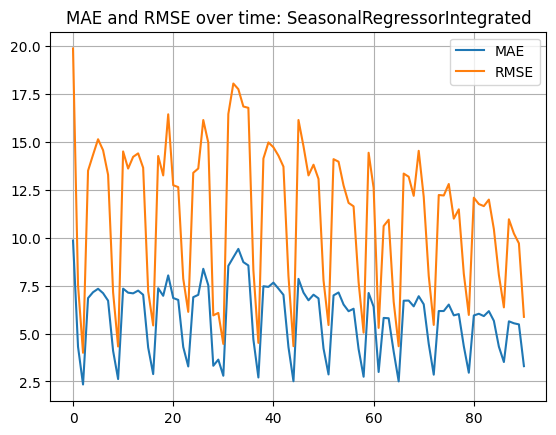

In [39]:
df = pd.read_csv("loader_f30avg_new.csv", index_col=0)

mae, rmse, mae_list, rmse_list_seasonal_integrated, seasonal_integrated_fimtdd = prequential_evaluation(
    SeasonalRegressorIntegrated,
    df,
    context_df=df_contextual_data,
    return_model = True,
    error_window=2400
)

In [40]:
df = df_contextual_data_not_lagged.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
columns = ['Flu_Like_Symptoms_Count','Dengue_Count','onibus','metro','festival','trem','greve']
daily_df = df[columns].resample('1D').mean()
daily_df = daily_df.reset_index()
daily_df = daily_df[:-1]

In [41]:
daily_df['Model_RMSE'] = rmse_list_seasonal_integrated

In [43]:
maxlag = 14

In [42]:
daily_df

,Timestamp,Flu_Like_Symptoms_Count,Dengue_Count,onibus,metro,festival,trem,greve,Model_RMSE
0,2024-03-01,505.0,276.0,46.0,5.0,10.0,13.0,0.0,19.861352
1,2024-03-02,97.0,53.0,51.0,5.0,10.0,10.0,0.0,7.521594
2,2024-03-03,110.0,72.0,45.0,0.0,12.0,21.0,0.0,3.993775
3,2024-03-04,524.0,306.0,46.0,4.0,8.0,13.0,4.0,13.489789
4,2024-03-05,414.0,229.0,42.0,4.0,10.0,8.0,7.0,14.320481
...,...,...,...,...,...,...,...,...,...
86,2024-05-26,73.0,38.0,48.0,5.0,15.0,9.0,17.0,6.363169
87,2024-05-27,222.0,117.0,74.0,7.0,10.0,13.0,69.0,10.957002
88,2024-05-28,192.0,111.0,84.0,0.0,12.0,9.0,100.0,10.212924
89,2024-05-29,155.0,95.0,50.0,5.0,7.0,8.0,30.0,9.700282


In [46]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.

    Citation: https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [49]:
granger_matrix = grangers_causation_matrix(daily_df,['Flu_Like_Symptoms_Count', 'Dengue_Count', 'onibus',
       'metro', 'festival', 'trem', 'greve', 'Model_RMSE'])

/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/envs/capymoa/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/cthm1/miniconda3/en

In [53]:
granger_matrix < 0.05/(64) #Bonferroni correction

,Flu_Like_Symptoms_Count_x,Dengue_Count_x,onibus_x,metro_x,festival_x,trem_x,greve_x,Model_RMSE_x
Flu_Like_Symptoms_Count_y,False,False,False,False,False,True,False,True
Dengue_Count_y,False,False,False,False,False,True,False,True
onibus_y,False,False,False,False,False,False,False,False
metro_y,True,False,False,False,False,False,True,True
festival_y,False,False,False,True,False,False,True,False
trem_y,False,False,False,False,False,False,False,True
greve_y,True,True,False,False,False,False,False,False
Model_RMSE_y,False,False,True,False,False,False,True,False


The error of the model granger-causes flu-symptoms and dengue -- suggesting potential causation between public transport volumes and these diseases.

Searches for 'onibus' and 'greve' granger-cause the error of the model.